tensor([[0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.5000, 0.5000, 0.0000, 0.5000],
        [0.9900, 0.9900, 0.0100, 0.0000, 0.0000, 0.0100, 0.0000]],
       requires_grad=True)


/var/folders/4g/4wgckcgj2zj9dw499ypxcwn80000gn/T/ipykernel_51712/14509574.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(Observation[:, obs]).requires_grad_(True)


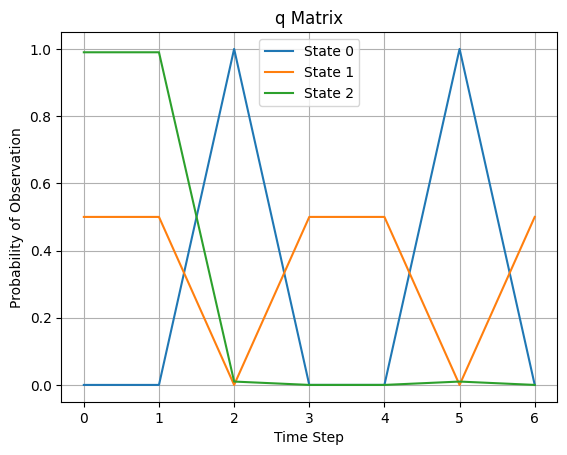

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm.auto as tqdm
import params

states = torch.tensor([0, 1, 2])
Transition = torch.tensor([[0, 1/2, 1/2],
                           [1/2, 0, 1/2],
                           [1/2, 1/2, 0]])
obs = torch.tensor([0, 0, 2, 1, 1, 2, 1])
Observation = torch.tensor([[0, 1/2, .99],
                            [0, 1/2, 0],
                            [1, 0, .01]]).T
Duration = torch.tensor([[1, 0, 0, 0],
                         [0, 1, 0, 0],
                         [0, 0, 1, 0]])

def q_matrix(obs, Observation):
    return torch.tensor(Observation[:, obs]).requires_grad_(True)

q = q_matrix(obs, Observation)
print(q)

# plot
time_steps = range(len(obs))
plt.figure()
for state in states:
    probs = [q[state][i].detach().numpy() for i in range(len(obs))]
    plt.plot(time_steps, probs, label=f"State {state}")

plt.xlabel('Time Step')
plt.ylabel('Probability of Observation')
plt.title('q Matrix')
plt.legend()
plt.grid(True)
plt.show()

In [289]:
def matrix_mult_factor(log_alpha_row, Transition):
    """
    returns a scalar
    """
    alpha_row = torch.exp(log_alpha_row)
    # alpha_row = alpha_row.to(torch.float64)
    product = alpha_row @ Transition
    factor = torch.sum(product)
    return torch.log(factor)

def matrix_mult_vec(log_alpha_row, Transition):
    """
    returns a vectors with dimensions (1, 9)
    """
    # log_alpha_row = log_alpha_row.to(torch.float64)
    result = torch.exp(log_alpha_row)@Transition
    if torch.sum(result) != 0:
        return torch.log(result / torch.sum(result))
    else:
        return torch.zeros_like(result)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

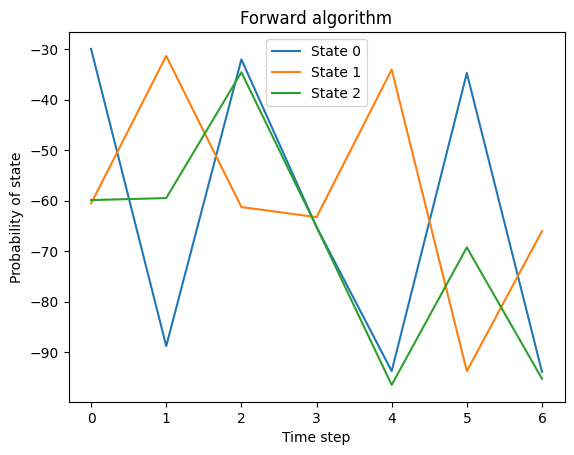

In [295]:
def forward(states, Transition, q, Duration):
    T = len(q[0])
    N = len(states)
    D = len(Duration[0])
    # log_alpha_list = []
    log_alpha = torch.zeros((T, N))
    start = torch.zeros(N)
    start[0] = 1
    epsilon = 1e-13

    Transition_ep = Transition + epsilon
    Duration_ep = Duration + epsilon
    q_ep = q + epsilon
    start_ep = start + epsilon

    cum_q_ep = torch.cumsum(torch.log(q_ep), axis=1)

    # initialization
    for t in tqdm.trange(min(D, T)):
        cumulative_terms = cum_q_ep[:, t]
        # new_log_alpha = torch.log(start_ep) + torch.log(Duration_ep[:, t]) + torch.sum(torch.log(q_ep[:, :t+1]), dim=1)
        log_alpha[t] = torch.log(start_ep) + torch.log(Duration_ep[:, t]) + torch.sum(torch.log(q_ep[:, :t+1]), dim=1)
        for d in range(t):
            factor = torch.column_stack([matrix_mult_factor(log_alpha[t-d-1], Transition_ep)]*N) # calculate ahead of time
            vector = matrix_mult_vec(log_alpha[t-d-1], Transition_ep) # same as above
            subtract_term = 0 if t-d == 0 else cum_q_ep[:, t-d-1]
            add_term = factor + vector + torch.log(Duration_ep[:, d]) + cumulative_terms - subtract_term # try to calcualte in one go
            log_alpha[t] = torch.logaddexp(log_alpha[t], add_term).squeeze()
        
    # fill log_alpha[D:]
    for t in tqdm.trange(D, T):
        cumulative_terms = cum_q_ep[:, t]
        # log_alpha_list.append(torch.full((N,), -float('inf')))
        # new_log_alpha = log_alpha_list[t]
        log_alpha[t] = torch.full((N,), -float('inf'))
        for d in range(D):
            factor = torch.column_stack([matrix_mult_factor(log_alpha[t-d-1], Transition_ep)]*N)
            vector = matrix_mult_vec(log_alpha[t-d-1], Transition_ep)
            subtract_term = 0 if t-d == 0 else cum_q_ep[:, t-d-1]
            add_term = factor + vector + torch.log(Duration_ep[:, d]) + cumulative_terms - subtract_term
            log_alpha[t] = torch.logaddexp(log_alpha[t], add_term).squeeze()
        # log_alpha_list[t] = new_log_alpha

    log_alpha = torch.exp(log_alpha)
    return log_alpha


fwd = forward(states, Transition, q, Duration).detach().numpy()

# plot
for state in states:
    probs = [fwd[t][state] for t in range(len(q[0]))]
    plt.plot(time_steps, np.log(probs), label =f"State {state}")

plt.xlabel('Time step')
plt.ylabel('Probability of state')
plt.title('Forward algorithm')
plt.legend()
plt.show()

In [326]:
def forward(states, Transition, q, Duration):
    T = len(q[0])
    N = len(states)
    D = len(Duration[0])
    log_alpha = torch.zeros((T, N))
    start = torch.zeros(N)
    start[0] = 1
    epsilon = 1e-13

    Transition_ep = Transition + epsilon
    Duration_ep = Duration + epsilon
    q_ep = q + epsilon
    start_ep = start + epsilon

    cum_q_ep = torch.cumsum(torch.log(q_ep), axis=1)

    # # initialization
    # for t in tqdm.trange(min(D, T)):
    #     cumulative_terms = cum_q_ep[:, t]
    #     log_alpha[t] = torch.log(start_ep) + torch.log(Duration_ep[:, t]) + torch.sum(torch.log(q_ep[:, :t+1]), dim=1)
    #     for d in range(t):
    #         factor = torch.column_stack([matrix_mult_factor(log_alpha[t-d-1], Transition_ep)]*N) # calculate ahead of time
    #         # print(factor.shape)
    #         vector = matrix_mult_vec(log_alpha[t-d-1], Transition_ep) # same as above
    #         # print(vector.shape)
    #         subtract_term = 0 if t-d == 0 else cum_q_ep[:, t-d-1]
    #         print(subtract_term)
    #         add_term = factor + vector + torch.log(Duration_ep[:, d]) + cumulative_terms - subtract_term # try to calcualte in one go
    #         log_alpha[t] = torch.logaddexp(log_alpha[t], add_term).squeeze()

    # initialization
    for t in tqdm.trange(min(D, T)):
        cumulative_terms = cum_q_ep[:, t]
        log_alpha[t] = torch.log(start_ep) + torch.log(Duration_ep[:, t]) + torch.sum(torch.log(q_ep[:, :t+1]), dim=1)
        # print(log_alpha[t])
        valid_d = torch.arange(t)
        log_alpha_idx = t-valid_d-1
        log_alphas = log_alpha[log_alpha_idx]
        factors = torch.stack([matrix_mult_factor(log_alphas, Transition_ep)]*N)
        vectors = matrix_mult_vec(log_alphas, Transition_ep)
        print(vectors)
        subtract_terms = cum_q_ep[:, log_alpha_idx].T
        print(factors.shape, vectors.shape, subtract_terms.shape, cumulative_terms.shape, torch.log(Duration_ep[:, valid_d]).T.shape)
        print(factors, vectors)
        add_terms = factors + vectors + torch.log(Duration_ep[:, valid_d].T) + cumulative_terms - subtract_terms
        log_alpha[t] = torch.logaddexp(log_alpha[t], add_terms).squeeze()
        
        
    # fill log_alpha[D:]
    for t in tqdm.trange(D, T):
        cumulative_terms = cum_q_ep[:, t]
        log_alpha[t] = torch.full((N,), -float('inf'))
        for d in range(D):
            factor = torch.column_stack([matrix_mult_factor(log_alpha[t-d-1], Transition_ep)]*N)
            vector = matrix_mult_vec(log_alpha[t-d-1], Transition_ep)
            subtract_term = 0 if t-d == 0 else cum_q_ep[:, t-d-1]
            add_term = factor + vector + torch.log(Duration_ep[:, d].T) + cumulative_terms - subtract_term
            log_alpha[t] = torch.logaddexp(log_alpha[t], add_term).squeeze()

    log_alpha = torch.exp(log_alpha)
    return log_alpha


fwd = forward(states, Transition, q, Duration).detach().numpy()

# plot
for state in states:
    probs = [fwd[t][state] for t in range(len(q[0]))]
    plt.plot(time_steps, np.log(probs), label =f"State {state}")

plt.xlabel('Time step')
plt.ylabel('Probability of state')
plt.title('Forward algorithm')
plt.legend()
plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]

tensor([], size=(0, 3))
torch.Size([3]) torch.Size([0, 3]) torch.Size([0, 3]) torch.Size([3]) torch.Size([0, 3])
tensor([-inf, -inf, -inf], grad_fn=<StackBackward0>) tensor([], size=(0, 3))


RuntimeError: expand(torch.FloatTensor{[0, 3]}, size=[3]): the number of sizes provided (1) must be greater or equal to the number of dimensions in the tensor (2)

tensor([[2.0000, 2.0000, 2.0000, 1.0000, 1.0000, 1.0000, 0.0000],
        [2.5000, 2.0000, 1.5000, 1.5000, 1.0000, 0.5000, 0.5000],
        [2.0000, 1.0100, 0.0200, 0.0100, 0.0100, 0.0100, 0.0000]],
       grad_fn=<FlipBackward0>)


  0%|          | 0/4 [00:00<?, ?it/s]

tensor([0.0000, 0.5000, 0.0000], grad_fn=<SubBackward0>)
tensor([[0.0000, 0.5000, 0.5000],
        [0.5000, 0.0000, 0.5000],
        [0.5000, 0.5000, 0.0000]]) tensor([1, 0, 0])
tensor([1.0000, 0.5000, 0.0100], grad_fn=<SubBackward0>)
tensor([[0.0000, 0.5000, 0.5000],
        [0.5000, 0.0000, 0.5000],
        [0.5000, 0.5000, 0.0000]]) tensor([0, 1, 0])
tensor([1.0000, 1.0000, 0.0100], grad_fn=<SelectBackward0>)
tensor([[0.0000, 0.5000, 0.5000],
        [0.5000, 0.0000, 0.5000],
        [0.5000, 0.5000, 0.0000]]) tensor([0, 0, 1])


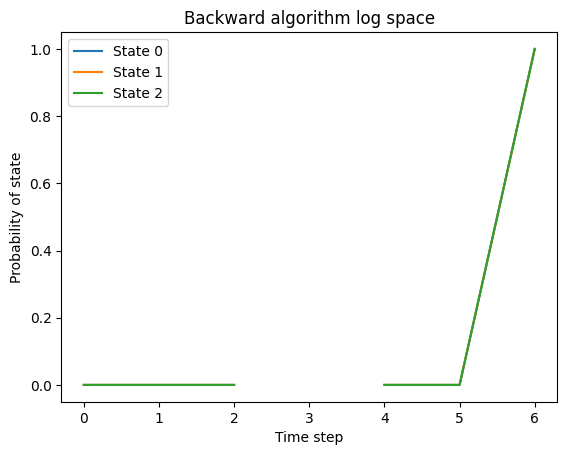

In [245]:
def backward(states, Transition, q, Duration):
    T = len(q[0])
    N = len(states)
    D = len(Duration[0])
    # epsilon = 1e-13
    epsilon =0
    # log_beta = torch.full((T, N), -float('inf'))
    log_beta = torch.zeros((T, N))

    # Transition_ep = torch.log(Transition + epsilon)
    # Duration_ep = torch.log(Duration + epsilon)
    Transition_ep = (Transition + epsilon)
    Duration_ep = (Duration + epsilon)
    q_ep = q + epsilon
    cum_q_ep = (torch.flip(torch.cumsum(torch.flip((q_ep), dims=[1]), dim=1), dims=[1]))
    print(cum_q_ep)

    # initialization, log_beta[-1]
    log_beta[-1] = torch.ones(N)

    # fill log_beta[:-1]
    for t in tqdm.trange(T - 4, -1, -1):
        # cumulative_terms = cum_q_ep[:, t+1]
        for d in range(D):
            if t+d <= T-2:
                cumulative_terms = cum_q_ep[:, t+1] if t+d == T-2 else cum_q_ep[:, t+1] - cum_q_ep[:, t+d+2]
                print(cumulative_terms)
                # print(t, d)
                # print(cum_q_ep[:, t+1], cum_q_ep[:, t+d+2], cum_q_ep)
                # print(log_beta, log_beta[t+d+1])
                print(Transition_ep, Duration_ep[:, d])
                log_beta[t] = torch.exp(torch.logaddexp(log_beta[t],
                                                torch.logsumexp(
                                                    torch.row_stack([log_beta[t+d+1]]*N)
                                                    + Transition_ep
                                                    + Duration_ep[:, d]
                                                    + cumulative_terms, axis=1)))
            else:
                break
        break

    # log_beta = torch.exp(log_beta)
    return log_beta

bwd = backward(states, Transition, q, Duration).detach().numpy()

# plot
for state in states:
    probs = [bwd[t][state] for t in range(len(q[0]))]
    plt.plot(range(len(q[0])), (probs), label=f"State {state}")

plt.xlabel('Time step')
plt.ylabel('Probability of state')
plt.title('Backward algorithm log space')
plt.legend()
plt.show()

  0%|          | 0/2 [00:00<?, ?it/s]

tensor([-inf, -inf, -inf], grad_fn=<SelectBackward0>)
tensor([-inf, -inf, -inf], grad_fn=<SelectBackward0>)


  0%|          | 0/2 [00:00<?, ?it/s]

tensor([-inf, -inf, -inf], grad_fn=<SelectBackward0>)
tensor([-inf, -inf, -inf], grad_fn=<SelectBackward0>)


/var/folders/4g/4wgckcgj2zj9dw499ypxcwn80000gn/T/ipykernel_51712/755228555.py:59: RuntimeWarning: divide by zero encountered in log
  plt.plot(range(len(q[0])), np.log(probs), label=f"State {state}")


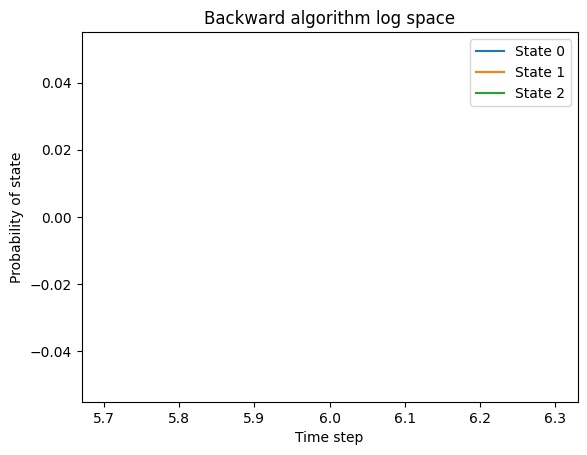

In [281]:
def backward(states, Transition, q, Duration):
    T = len(q[0])
    N = len(states)
    D = len(Duration[0])
    epsilon = 1e-13
    log_beta = torch.full((T, N), -float('inf'))

    Transition_ep = torch.log(Transition + epsilon)
    Duration_ep = torch.log(Duration + epsilon)
    q_ep = q + epsilon

    cum_q_ep = torch.cumsum(torch.log(q_ep.flip(dims=[1])), dim=1).flip(dims=[1])

    # initialization, log_beta[-1]
    log_beta[-1] = torch.zeros(N)

    for t in tqdm.trange(T - 6, -1, -1):
        darray = []
        for d in range(D):
            if t+d <= T-2:
                darray.append(d)
                cumulative_terms = cum_q_ep[:, t+1] if t+d == T-2 else cum_q_ep[:, t+1] - cum_q_ep[:, t+d+2]
                log_beta[t] = torch.logaddexp(log_beta[t],
                                                torch.logsumexp(
                                                    torch.row_stack([log_beta[t+d+1]]*N)
                                                    + Transition_ep
                                                    + Duration_ep[:, d]
                                                    + cumulative_terms, axis=1))
            else:
                break
        # print(darray)
        print(log_beta[t])

    # d should go in first dimension
    for t in tqdm.trange(T - 6, -1, -1):
        valid_d = torch.arange(min(D, T-t-1)) # 2
        # print(valid_d)
        log_beta_idx = t + valid_d + 1
        log_betas = log_beta[log_beta_idx]
        stacked_log_betas = log_betas.unsqueeze(1).repeat(1, N, 1)
        # print(stacked_log_betas, stacked_log_betas.shape) # 2, 3, 3
        valid_durations = Duration_ep[:, valid_d].T.unsqueeze(1) # 2, 1, 3
        valid_cum_terms = cum_q_ep[:, t+1] - cum_q_ep[:, t+valid_d[:-1]+2].T.flip(dims=[0])
        valid_cum_terms = torch.cat([valid_cum_terms, cum_q_ep[:, t+1].unsqueeze(0)], dim=0).unsqueeze(1) # 2, 1, 3
        # print(torch.logsumexp(stacked_log_betas + Transition_ep + valid_durations + valid_cum_terms, dim=2)[-1])
        log_beta[t] = torch.logsumexp(stacked_log_betas + Transition_ep + valid_durations + valid_cum_terms, dim=2)[-1]
        print(log_beta[t])
    log_beta = torch.exp(log_beta)
    return log_beta

# zero = torch.zeros(2, 3, 3)
# print((zero + Transition))

bwd = backward(states, Transition, q, Duration).detach().numpy()

# plot
for state in states:
    probs = [bwd[t][state] for t in range(len(q[0]))]
    plt.plot(range(len(q[0])), np.log(probs), label=f"State {state}")

plt.xlabel('Time step')
plt.ylabel('Probability of state')
plt.title('Backward algorithm log space')
plt.legend()
plt.show()

In [37]:
import torch

# Example 2D tensor
tensor = torch.tensor([[1, 2, 3, 4, 5], 
                       [6, 7, 8, 9, 10]])

# Flip the columns (reverse the order of columns)
flipped_tensor = torch.flip(tensor, dims=[1])

# To demonstrate the output
print("Original Tensor:\n", tensor)
print("Flipped Tensor (Columns Reversed):\n", flipped_tensor)

# Compute the cumulative sum on the reversed tensor
cumsum_reversed = torch.cumsum(flipped_tensor, dim=1)

# Reverse the cumsum result to get the final output
result_tensor = torch.flip(cumsum_reversed, dims=[1])

# To demonstrate the output
print("Flipped Cumulative Sum Tensor:\n", cumsum_reversed)
print("Result Tensor:\n", result_tensor)

Original Tensor:
 tensor([[ 1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10]])
Flipped Tensor (Columns Reversed):
 tensor([[ 5,  4,  3,  2,  1],
        [10,  9,  8,  7,  6]])
Flipped Cumulative Sum Tensor:
 tensor([[ 5,  9, 12, 14, 15],
        [10, 19, 27, 34, 40]])
Result Tensor:
 tensor([[15, 14, 12,  9,  5],
        [40, 34, 27, 19, 10]])
